# Proposta para OSS2025
![Quarta Arquitetura do Grupo](arc4.png)

- tentar ver o que a yolo está a detetar
- vale a pena usar os 4
- referenciar o artigo
- fine tuning pontual
- criar readme com todos os imports
- gpu a 0 e sem memoria, tem que levar reset


## O que pode ser "Tuned"

### Clip
- Versão do CLIP -> (https://pypi.org/project/open-clip-torch/)
- Escolher os pesos/pre-treino
- Shape: atualmente (8,3,244,244) # T,C,H,W
### R3D
- R3D com ou sem pre-treino -> (https://docs.pytorch.org/vision/main/models/generated/torchvision.models.video.r3d_18.html#torchvision.models.video.r3d_18)
- Shape: atualmente (4,16,3,244,244)
- Pode ser alterado para outro transformer, tipo Video Swin
### Yolo
- Versão da Yolo (https://docs.ultralytics.com/pt/#where-to-start)
- Qual camada intermédia escolher para o hook: atualmente -10
- Shape: atualmente (3,640,640) # C,H,W

### Temporal Transfomer
- Número de cabeças
- Número de camadas
- Número de Features FeadFoward, convém ser o mesmo que visual_dim
- Regularização dropout

### Cross Transformer

- Número de cabeças
- Número de camadas

### Geral
- O tamanho das projeções: visual_dim = 512
- O tamanho do Batch: atualmente a 2
- O Número de clips 2D: 8
- O Número de clips 3D: 4
- O Número de frames por clip 3d: 16

# Imports

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
from PIL import Image
import open_clip
import gc
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
import torch.nn as nn
from torch.nn import BatchNorm2d
from torch.nn import Dropout2d
from torch.nn import Sequential
from torch.nn import Linear
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
import torch.nn.functional as F
import cv2

import torchvision.transforms as transforms
from torchvision.io import read_video
import torchvision.io as tvio   
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchinfo import summary
from torch.utils.data import Dataset
from torchvision.io import read_video
from torchvision import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler


from livelossplot import PlotLosses

np.random.seed(0) 
torch.manual_seed(0)
import random
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# Setup

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
         for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

device = get_default_device()
print(device)

cuda


# Dataset

In [3]:
import os
import cv2
import random
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd

class MultiStreamVideoDataset(Dataset):
    def __init__(
        self,
        video_dir,
        label_path,
        clip_preprocess,
        num_2d_frames=8,
        num_3d_clips=4,
        frames_per_clip=16,
        transform_3d=None,
        yolo_resize=None,
    ):
        self.video_dir = video_dir
        self.clip_preprocess = clip_preprocess
        self.num_2d_frames = num_2d_frames
        self.num_3d_clips = num_3d_clips
        self.frames_per_clip = frames_per_clip

        self.transform_3d = transform_3d or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ConvertImageDtype(torch.float32)
        ])

        self.yolo_resize = yolo_resize or transforms.Compose([
            transforms.Resize((640, 640)),
            transforms.ToTensor()
        ])

        self.labels_dict = self._load_labels(label_path)

        self.videos = [
            f for f in os.listdir(video_dir)
            if f.endswith(".mp4") and os.path.splitext(f)[0] in self.labels_dict
        ]
        print(f"Found {len(self.videos)} labeled videos")

    def _load_labels(self, path):
        if not os.path.exists(path):
            print(f"Warning: Label file not found: {path}")
            return {}

        try:
            df = pd.read_excel(path)

            if "VIDEO" not in df.columns:
                raise ValueError("Missing 'VIDEO' column.")

            # Only keep OSATS columns + VIDEO
            osats_cols = [
                "OSATS_RESPECT", "OSATS_MOTION", "OSATS_INSTRUMENT", "OSATS_SUTURE",
                "OSATS_FLOW", "OSATS_KNOWLEDGE", "OSATS_PERFORMANCE", "OSATS_FINAL_QUALITY"
            ]

            df = df[["VIDEO"] + osats_cols]

            # Convert scores from 1-5 to 0-4
            df[osats_cols] = df[osats_cols] - 1

            # Sanity check: all values between 0 and 4
            if not ((df[osats_cols] >= 0) & (df[osats_cols] <= 4)).all().all():
                raise ValueError("One or more OSATS scores are outside the expected 0–4 range.")

            # Group by VIDEO and average (in case of duplicates)
            df = df.groupby("VIDEO").mean()

            # Final label dict
            return {video: row.values.tolist() for video, row in df.iterrows()}

        except Exception as e:
            print(f"Error loading labels: {e}")
            return {}

    def __len__(self):
        return len(self.videos)

    def _sample_indices(self, total_frames, num_samples):
        if total_frames < num_samples:
            return [i % total_frames for i in range(num_samples)]
        return sorted(random.sample(range(total_frames), num_samples))

    def _cv2_to_tensor(self, frame):
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        return Image.fromarray(frame_rgb)

    def __getitem__(self, idx):
        video_file = self.videos[idx]
        video_name = os.path.splitext(video_file)[0]
        label_list = self.labels_dict[video_name]
        label_tensor = torch.tensor(label_list, dtype=torch.long)  # (8,)

        video_path = os.path.join(self.video_dir, video_file)
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise ValueError(f"Could not open video file: {video_path}")
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        idx_2d = self._sample_indices(total_frames, self.num_2d_frames)

        clip_start_indices = []
        for _ in range(self.num_3d_clips):
            if total_frames < self.frames_per_clip:
                start_idx = 0
            else:
                start_idx = random.randint(0, total_frames - self.frames_per_clip)
            clip_start_indices.append(start_idx)

        clip_indices = []
        for start_idx in clip_start_indices:
            clip_indices.extend(range(start_idx, start_idx + self.frames_per_clip))
        all_needed_indices = sorted(set(idx_2d + clip_indices))

        frame_dict = {}
        current_frame = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if current_frame in all_needed_indices:
                frame_dict[current_frame] = self._cv2_to_tensor(frame)
            current_frame += 1
            if current_frame > max(all_needed_indices) and len(frame_dict) == len(all_needed_indices):
                break
        cap.release()

        # 2D CLIP frames
        frames_2d = [self.clip_preprocess(frame_dict.get(i, frame_dict[max(frame_dict.keys())])) for i in idx_2d]
        frames_2d = torch.stack(frames_2d)  # (T, C, H, W)

        # YOLO frame
        first_frame = frame_dict.get(idx_2d[0], frame_dict[max(frame_dict.keys())])
        yolo_frame = self.yolo_resize(first_frame)  # (C, 640, 640)

        # 3D R3D clips
        clips_3d = []
        for start_idx in clip_start_indices:
            clip_frames = [frame_dict.get(i, frame_dict[max(frame_dict.keys())]) for i in range(start_idx, start_idx + self.frames_per_clip)]
            processed = [self.transform_3d(transforms.ToTensor()(f)) for f in clip_frames]
            clip = torch.stack(processed).permute(1, 0, 2, 3)  # (C, T, H, W)
            clips_3d.append(clip)
        clips_3d = torch.stack(clips_3d)  # (S, C, T, H, W)

        return frames_2d, clips_3d, yolo_frame, label_tensor


# Dataloader

In [4]:
BATCH_SIZE = 4
NUM_2D_FRAMES = 8
NUM_3D_CLIPS = 4
FRAMES_PER_CLIP = 16 

# Create CLIP preprocessing
_, _, clip_preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained='laion2b_s34b_b79k')

# Create training dataset
train_dataset = MultiStreamVideoDataset(
    video_dir="/mounts/OSS_dataset/Train/videos/",
    label_path="/mounts/OSS_dataset/Train/OSATS.xlsx",
    clip_preprocess=clip_preprocess,
    num_2d_frames=NUM_2D_FRAMES,
    num_3d_clips=NUM_3D_CLIPS,
    frames_per_clip=FRAMES_PER_CLIP,
)

# Create test dataset
test_dataset = MultiStreamVideoDataset(
    video_dir="/mounts/OSS_dataset/Train/videos/",
    label_path="/mounts/OSS_dataset/Test/OSATS.csv",
    clip_preprocess=clip_preprocess,
    num_2d_frames=NUM_2D_FRAMES,
    num_3d_clips=NUM_3D_CLIPS,
    frames_per_clip=FRAMES_PER_CLIP,
)

# Split training data into train/validation sets (80%/20%)
train_indices = list(range(len(train_dataset)))
train_idx, val_idx = train_test_split(train_indices, test_size=0.2, random_state=0)

# Create train and validation datasets by subsetting the training dataset
train_subset = torch.utils.data.Subset(train_dataset, train_idx)
val_subset = torch.utils.data.Subset(train_dataset, val_idx)

print(f"Train: {len(train_subset)} samples, Validation: {len(val_subset)} samples, Test: {len(test_dataset)} samples")

# Create data loaders
train_loader = DataLoader(
    train_subset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True
)

val_loader = DataLoader(
    val_subset, 
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True
)


Found 314 labeled videos
Error loading labels: Excel file format cannot be determined, you must specify an engine manually.
Found 0 labeled videos
Train: 251 samples, Validation: 63 samples, Test: 0 samples


# Train

## Func

In [5]:
# Import metrics from the MICCAI24 package
from metrics4MICCAI24.expected_cost import get_expected_cost
from metrics4MICCAI24.utils import get_multi_class_confusion_matrix
from metrics4MICCAI24.utils import load_csv, get_multiclass_tp_tn_fp_fn

NUM_OSATS_LABELS = 8
NUM_CLASSES_PER_LABEL = 5  # 0–4

def get_f1(data_df, num_classes=5):
    """
    Calculate the F1 score for the given data.
    Args:
        data_df: dataframe with columns 'item_id', 'ground_truth', 'prediction'.
        num_classes: number of classes.

    Returns:
        float: The F1 score.
    """
    tp, tn, fp, fn, _ = get_multiclass_tp_tn_fp_fn(data_df, num_classes)
    f1_scores = []
    for i in range(num_classes):
        if tp[i] + fp[i] > 0 and tp[i] + fn[i] > 0 and tp[i] > 0:
            precision = tp[i] / (tp[i] + fp[i])
            recall = tp[i] / (tp[i] + fn[i])
            f1 = 2 * precision * recall / (precision + recall)
            f1_scores.append(f1)
        else:
            f1_scores.append(0)
    print(f1_scores)
    return sum(f1_scores) / len(f1_scores)


def _create_task_df(labels, preds, task_index):
    """Create a DataFrame for a single OSATS task from batch predictions."""
    return pd.DataFrame({
        'item_id': list(range(len(labels))),
        'ground_truth': [label[task_index] for label in labels],
        'prediction': [pred[task_index] for pred in preds]
    })

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_labels = []
    all_preds = []

    for frames_2d, clips_3d, yolo, labels in tqdm(dataloader, desc="Training"):
        frames_2d = frames_2d.to(device)
        clips_3d = clips_3d.to(device)
        yolo = yolo.to(device)
        labels = labels.to(device)  # (B, 8)

        outputs = model(frames_2d, clips_3d, yolo)  # (B, 8, 5)

        # Compute loss for each OSATS label
        loss = sum(criterion(outputs[:, i, :], labels[:, i]) for i in range(NUM_OSATS_LABELS)) / NUM_OSATS_LABELS

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * frames_2d.size(0)

        preds = outputs.argmax(dim=-1)  # (B, 8)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss, all_preds, all_labels

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for frames_2d, clips_3d, yolo, labels in tqdm(dataloader, desc="Validation"):
            frames_2d = frames_2d.to(device)
            clips_3d = clips_3d.to(device)
            yolo = yolo.to(device)
            labels = labels.to(device)

            outputs = model(frames_2d, clips_3d, yolo)
            loss = sum(criterion(outputs[:, i, :], labels[:, i]) for i in range(NUM_OSATS_LABELS)) / NUM_OSATS_LABELS

            running_loss += loss.item() * frames_2d.size(0)

            preds = outputs.argmax(dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss, all_preds, all_labels

def test(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []
    item_ids = []

    with torch.no_grad():
        for batch_idx, (frames_2d, clips_3d, yolo, labels) in enumerate(tqdm(dataloader, desc="Testing")):
            frames_2d = frames_2d.to(device)
            clips_3d = clips_3d.to(device)
            yolo = yolo.to(device)
            labels = labels.to(device)

            outputs = model(frames_2d, clips_3d, yolo)
            preds = outputs.argmax(dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            ids = list(range(batch_idx * frames_2d.size(0), (batch_idx + 1) * frames_2d.size(0)))
            item_ids.extend(ids)

    return all_preds, all_labels, item_ids

from metrics4MICCAI24.expected_cost import get_expected_cost
from metrics4MICCAI24.utils import get_multi_class_confusion_matrix, get_multiclass_tp_tn_fp_fn

def train_model(
    model, 
    train_loader, 
    val_loader, 
    test_loader,
    num_epochs=5, 
    lr=0.001, 
    weight_decay=1e-4,  
    save_dir='checkpoints'
):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    os.makedirs(save_dir, exist_ok=True)

    liveloss = PlotLosses()
    best_val_f1 = 0.0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        train_loss, train_preds, train_labels = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_preds, val_labels = validate(model, val_loader, criterion, device)

        train_f1s, val_f1s = [], []
        train_costs, val_costs = [], []

        for task in range(NUM_OSATS_LABELS):
            df_train = _create_task_df(train_labels, train_preds, task)
            df_val = _create_task_df(val_labels, val_preds, task)

            train_f1s.append(get_f1(df_train))
            val_f1s.append(get_f1(df_val))

            train_costs.append(get_expected_cost(df_train, NUM_CLASSES_PER_LABEL))
            val_costs.append(get_expected_cost(df_val, NUM_CLASSES_PER_LABEL))

        avg_train_f1 = sum(train_f1s) / NUM_OSATS_LABELS
        avg_val_f1 = sum(val_f1s) / NUM_OSATS_LABELS
        avg_train_cost = sum(train_costs) / NUM_OSATS_LABELS
        avg_val_cost = sum(val_costs) / NUM_OSATS_LABELS

        logs = {
            'loss': train_loss,
            'val_loss': val_loss,
            'f1': avg_train_f1,
            'val_f1': avg_val_f1,
            'cost': avg_train_cost,
            'val_cost': avg_val_cost
        }

        liveloss.update(logs)
        liveloss.send()

        print(f"Train F1 (avg): {avg_train_f1:.4f} | Cost: {avg_train_cost:.4f}")
        print(f"Val   F1 (avg): {avg_val_f1:.4f} | Cost: {avg_val_cost:.4f}")

        if avg_val_f1 > best_val_f1:
            best_val_f1 = avg_val_f1
            best_model_path = os.path.join(save_dir, "best_model.pth")
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved to {best_model_path}")

    return model

def save_predictions_to_csv(item_ids, predictions, filename):
    """
    Save predictions to a CSV file in the format expected by MICCAI24.
    
    Args:
        item_ids: List of item IDs.
        predictions: List of predicted labels.
        filename: Name of the output file.
    """
    data = {
        'item_id': item_ids,
        'prediction': predictions
    }
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)
    print(f"Predictions saved to {filename}")

# Function to visualize confusion matrix
def plot_confusion_matrix(labels, predictions, num_classes=5, figsize=(10, 8)):
    """
    Plot confusion matrix for the predictions.
    
    Args:
        labels: Ground truth labels.
        predictions: Predicted labels.
        num_classes: Number of classes.
        figsize: Figure size (width, height).
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Create DataFrame for MICCAI24 metrics
    data_df = _create_metrics_dataframe(labels, predictions)
    
    # Get confusion matrix
    cm = get_multi_class_confusion_matrix(data_df, num_classes)
    
    # Plot
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

## First

In [6]:
from torchvision.models.video import r3d_18, R3D_18_Weights
from ultralytics import YOLO

class TemporalTransformer(nn.Module):
    def __init__(self, input_dim, num_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dim_feedforward=512,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        x = self.transformer(x)  # (B, T, D)
        return x.mean(dim=1)     # pooled (B, D)

# --- Cross-Attention Transformer ---
class CrossTransformer(nn.Module):
    def __init__(self, dim, num_heads=4, num_layers=1):
        super().__init__()
        layer = nn.TransformerEncoderLayer(d_model=dim, nhead=num_heads, batch_first=True)
        self.encoder = nn.TransformerEncoder(layer, num_layers=num_layers)

    def forward(self, query, context):
        x = torch.cat([query, context], dim=1)  # (B, 1+N, D)
        x = self.encoder(x)
        return x[:, 0]  # Return only the query token


# --- Full Model ---
class ClipStyleMultiStreamClassifierYoloMultilabel(nn.Module):
    def __init__(self, visual_dim=512, yolo_model_path='yolo11n.pt',
                 text_model="ViT-B-32", num_labels=8, num_classes=5, mlp_hidden_dim=256):
        super().__init__()
        self.num_labels = num_labels
        self.num_classes = num_classes

        # --- CLIP ---
        self.clip_model, _, _ = open_clip.create_model_and_transforms(text_model, pretrained="laion2b_s34b_b79k")
        self.clip_dim = self.clip_model.visual.output_dim

        # --- R3D ---
        self.r3d = r3d_18(weights=R3D_18_Weights.DEFAULT)
        self.r3d.fc = nn.Identity()
        self.r3d_dim = 512

        # --- YOLO ---
        self.yolo_model = YOLO(yolo_model_path).model
        self.yolo_model.eval()
        for p in self.yolo_model.parameters():
            p.requires_grad = False

        self.yolo_feat = None
        self._register_yolo_hook()

        dummy_input = torch.zeros(1, 3, 640, 640)
        with torch.no_grad():
            _ = self.yolo_model(dummy_input)
        assert self.yolo_feat is not None, "YOLO hook did not capture features"
        self.yolo_dim = self.yolo_feat.shape[1]

        # --- Projections ---
        self.clip_proj = nn.Linear(self.clip_dim, visual_dim)
        self.r3d_proj = nn.Linear(self.r3d_dim, visual_dim)
        self.yolo_proj = nn.Linear(self.yolo_dim, visual_dim)

        # --- Transformers ---
        self.temporal = TemporalTransformer(input_dim=visual_dim)
        self.cross_fusion = CrossTransformer(dim=visual_dim)

        # --- MLP Head ---
        self.head = nn.Sequential(
            nn.Linear(visual_dim, mlp_hidden_dim),
            nn.ReLU(),
            nn.Linear(mlp_hidden_dim, num_labels * num_classes)
        )

    def _register_yolo_hook(self):
        def hook_fn(module, input, output):
            self.yolo_feat = output

        # Choose a stable YOLO layer (adjust index if needed)
        target_layer = list(self.yolo_model.model.modules())[2]
        target_layer.register_forward_hook(hook_fn)

    def forward(self, frames_2d, clips_3d, yolo_frames):
        B, T, C, H, W = frames_2d.shape
        S, C3D, T3D, H3D, W3D = clips_3d.shape[1:]
        
        # --- CLIP ---
        frames_flat = frames_2d.view(B * T, C, H, W)
        with torch.no_grad():
            clip_feats = self.clip_model.encode_image(frames_flat)
        clip_feats = self.clip_proj(clip_feats).view(B, T, -1)
        temporal_summary = self.temporal(clip_feats).unsqueeze(1)  # (B, 1, D)

        # print("Done with CLIP")
        # --- R3D ---
        clips_3d = clips_3d.view(B * S, C3D, T3D, H3D, W3D)
        with torch.no_grad():
            r3d_feats = self.r3d(clips_3d)
        r3d_feats = self.r3d_proj(r3d_feats).view(B, S, -1)  # (B, S, D)
        # print("Done with R3D")
        # --- YOLO ---
        yolo_feats = []
        with torch.no_grad():
            for i in range(B):
                self.yolo_feat = None
                _ = self.yolo_model(yolo_frames[i].unsqueeze(0))
                assert self.yolo_feat is not None
                pooled = self.yolo_feat.mean(dim=[2, 3])  # GAP
                yolo_feats.append(pooled)
        yolo_feats = torch.cat(yolo_feats, dim=0)  # (B, C)
        yolo_feats = self.yolo_proj(yolo_feats).unsqueeze(1)  # (B, 1, D)
        # print("Done with YOLO")
        # --- Fusion ---
        context = torch.cat([r3d_feats, yolo_feats], dim=1)  # (B, S+1, D)
        fused = self.cross_fusion(temporal_summary, context)  # (B, D)
        # print("Done with Cross Fusion")
        # --- MLP Head ---
        output = self.head(fused)                  # (B, 8 * 5)
        output = output.view(B, self.num_labels, self.num_classes)  # (B, 8, 5)
        # print("Done with MLP")
        return output

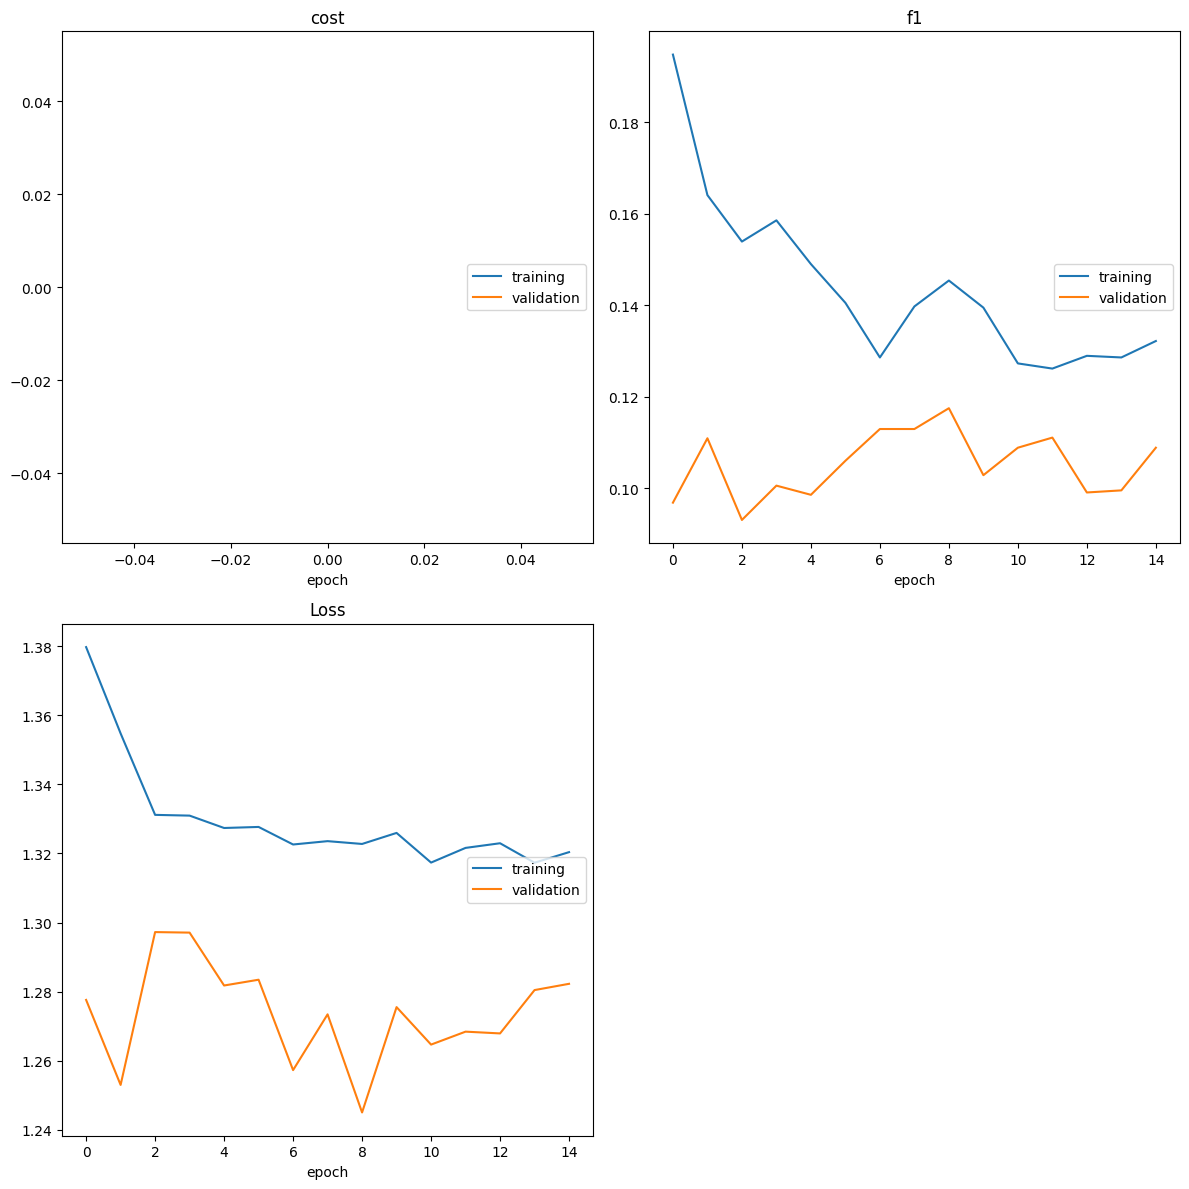

cost
	training         	 (min:      nan, max:      nan, cur:      nan)
	validation       	 (min:      nan, max:      nan, cur:      nan)
f1
	training         	 (min:    0.126, max:    0.195, cur:    0.132)
	validation       	 (min:    0.093, max:    0.118, cur:    0.109)
Loss
	training         	 (min:    1.317, max:    1.380, cur:    1.320)
	validation       	 (min:    1.245, max:    1.297, cur:    1.282)
Train F1 (avg): 0.1322 | Cost: nan
Val   F1 (avg): 0.1089 | Cost: nan

Epoch 16/20


Training:  24%|██▍       | 15/63 [15:41<50:11, 62.74s/it] 


KeyboardInterrupt: 

In [7]:


NUM_LABELS = 8   # 8 OSATS categories
NUM_CLASSES = 5  # Each category has 5 class scores (0–4)

model = ClipStyleMultiStreamClassifierYoloMultilabel(
    visual_dim=512,
    num_labels=NUM_LABELS,
    num_classes=NUM_CLASSES,
    yolo_model_path="yolo11n.pt"
)

model = train_model(
    model,
    train_loader,
    val_loader,
    test_loader,
    num_epochs=20,
    lr=0.001,
    weight_decay=1e-4,
    save_dir="task2_baseline",
)


# Second

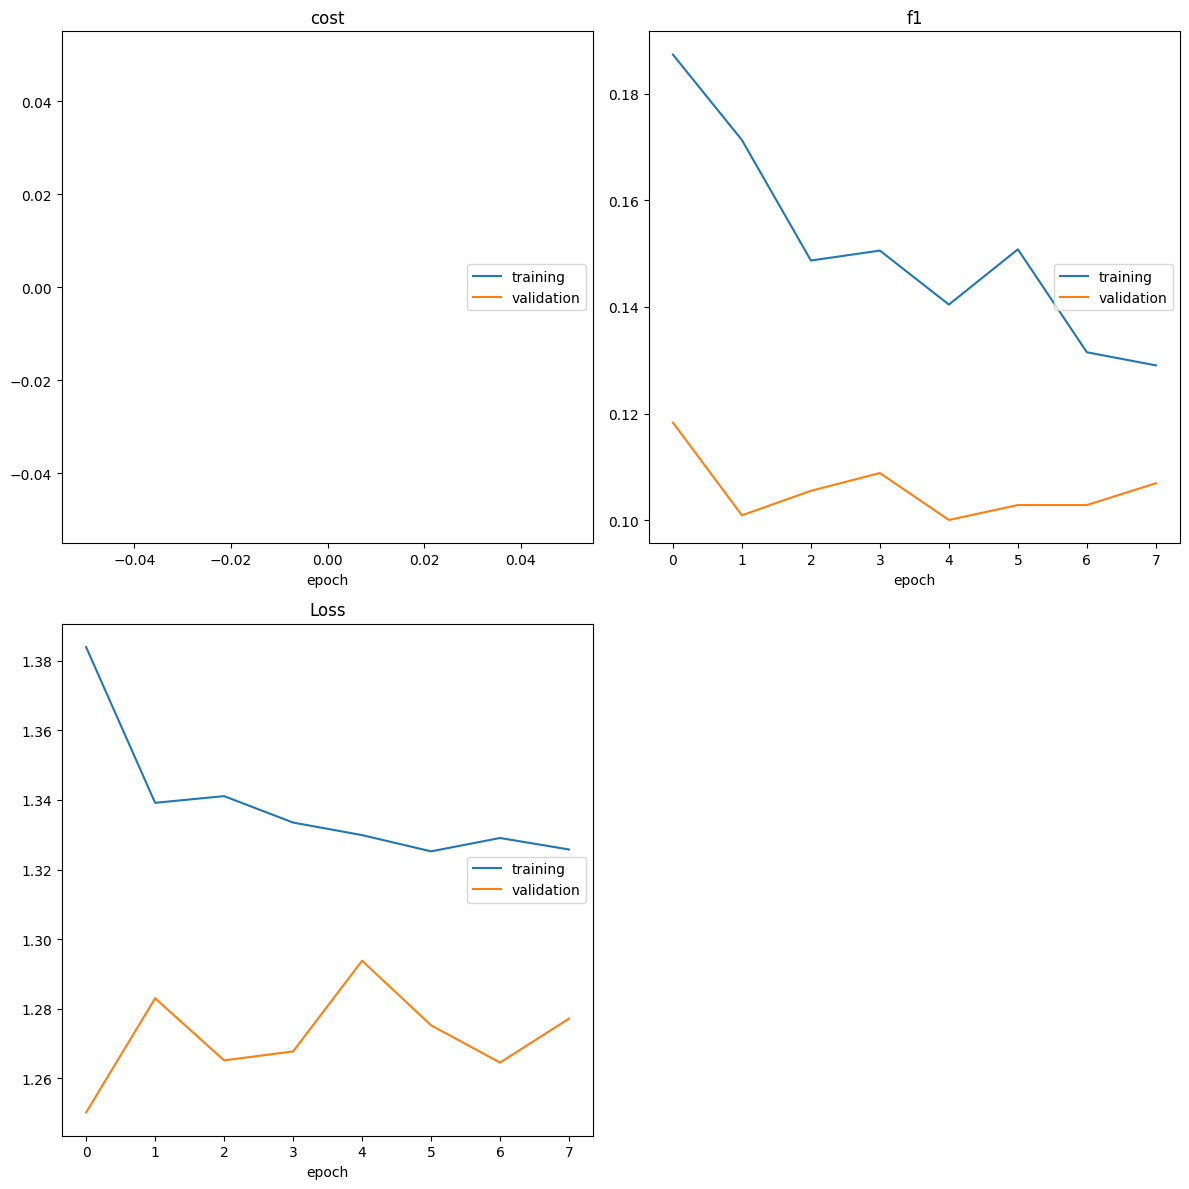

cost
	training         	 (min:      nan, max:      nan, cur:      nan)
	validation       	 (min:      nan, max:      nan, cur:      nan)
f1
	training         	 (min:    0.129, max:    0.187, cur:    0.129)
	validation       	 (min:    0.100, max:    0.118, cur:    0.107)
Loss
	training         	 (min:    1.325, max:    1.384, cur:    1.326)
	validation       	 (min:    1.250, max:    1.294, cur:    1.277)
Train F1 (avg): 0.1291 | Cost: nan
Val   F1 (avg): 0.1070 | Cost: nan

Epoch 9/10


Training:  83%|████████▎ | 52/63 [1:02:36<13:14, 72.23s/it]


KeyboardInterrupt: 

In [7]:
NUM_LABELS = 8   # 8 OSATS categories
NUM_CLASSES = 5  # Each category has 5 class scores (0–4)

model = ClipStyleMultiStreamClassifierYoloMultilabel(
    visual_dim=128,
    num_labels=NUM_LABELS,
    num_classes=NUM_CLASSES,
    yolo_model_path="yolo11n.pt"
)

model = train_model(
    model,
    train_loader,
    val_loader,
    test_loader,
    num_epochs=10,
    lr=0.001,
    weight_decay=1e-4,
    save_dir="task2_down_scaled",
)
